In [1]:
import os
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config import ALL_FNS
FN_NAMES = ["x ∧ y", "x ∨ y", "≠g x", "≠g y", "x ⊕ y", "(x + y)/2", "x·≠g y", "x", "y", "0.7"]

In [2]:
dataset = torch.load("dataset.pt", map_location="cpu", weights_only=False)
train_input = dataset["test"][0]
train_target = dataset["test"][1]


x, y = train_input[:, 0], train_input[:, 1]

def xor_one(x, y):
    """(x ∨ y) ∧ ≠g(x ∧ y)"""
    lor_term = x + y - x * y
    land_term = 1 - (x * y)
    return lor_term * land_term

def xor_two(x, y):
    """(x ∧ ≠g y) ∨ (≠g x ∧ y)"""
    lhs_term = x * (1 - y)
    rhs_term = (1 - x) * y
    return lhs_term + rhs_term - lhs_term * rhs_term

land = x * y 
lor = x + y - x * y
neqg_x = 1 - x
neqg_y = 1 - y
# Why doesn't the below work??
xor = xor_one(x, y)
xor2 = xor_two(x, y)
avg = (x + y) / 2
xneqgy = x * (1 - y)
x, y = x.numpy(), y.numpy()

assert torch.allclose(train_target["x ∧ y"], land.unsqueeze(1))
assert torch.allclose(train_target["x ∨ y"], lor.unsqueeze(1))
assert torch.allclose(train_target["≠g x"], neqg_x.unsqueeze(1))
assert torch.allclose(train_target["≠g y"], neqg_y.unsqueeze(1))
assert torch.allclose(train_target["x ⊕ y"], xor.unsqueeze(1))
# assert torch.allclose(train_target["x ⊕ y"], xor2.unsqueeze(1))
assert torch.allclose(train_target["(x + y)/2"], avg.unsqueeze(1))
assert torch.allclose(train_target["x·≠g y"], xneqgy.unsqueeze(1))

In [3]:
RESULTS_DIR = "new_conj2"

DIR_PATTERN = re.compile(r"(AN|AO|FC)-(\d+)-(\d+)")
FILE_PATTERN = re.compile(r"(\d+)-(\d+)(?:-(\d+))?.csv")

dfs = []
for root, dirs, files in os.walk(RESULTS_DIR):
    match = DIR_PATTERN.match(os.path.basename(root))
    if not match:
        continue

    model, layers, hidden_dim = match.groups()
    for file in files:
        match = FILE_PATTERN.match(file)
        if not match:
            continue

        fn_idx, seed, run_idx = match.groups()
        if run_idx is None:
            run_idx = 0

        df = pd.read_csv(os.path.join(root, file))

        df["model"] = model
        df["num_layers"] = int(layers)
        df["hidden_dim"] = int(hidden_dim)
        df["fn_name"] = ALL_FNS[int(fn_idx)][0]
        df["seed"] = int(seed)
        df["run_idx"] = int(run_idx)

        dfs.append(
            df[
                [
                    "seed",
                    "model",
                    "num_layers",
                    "hidden_dim",
                    "fn_name",
                    "run_idx",
                    "epoch",
                    *df.columns[1:5],
                ]
            ]
        )

df = pd.concat(dfs)
df

,seed,model,num_layers,hidden_dim,fn_name,run_idx,epoch,train_loss,test_loss,train_acc,test_acc
0,20493052,FC,2,100,(x + y)/2,2,1,0.010543,0.000467,0.0599,0.229
1,20493052,FC,2,100,(x + y)/2,2,2,0.001533,0.000390,0.1005,0.334
2,20493052,FC,2,100,(x + y)/2,2,3,0.001193,0.000329,0.1201,0.330
3,20493052,FC,2,100,(x + y)/2,2,4,0.000967,0.000241,0.1342,0.361
4,20493052,FC,2,100,(x + y)/2,2,5,0.000795,0.000216,0.1547,0.355
...,...,...,...,...,...,...,...,...,...,...,...
95,20492641,FC,4,5,y,0,96,0.023697,0.001866,0.0349,0.075
96,20492641,FC,4,5,y,0,97,0.023054,0.001866,0.0397,0.075
97,20492641,FC,4,5,y,0,98,0.022341,0.001866,0.0387,0.075
98,20492641,FC,4,5,y,0,99,0.023543,0.001866,0.0372,0.075


In [4]:
df_avg = (
    df[df["epoch"] == 100]
    .assign(
        architecture=lambda x: x["model"]
        + "-"
        + x["num_layers"].astype(str)
        + "-"
        + x["hidden_dim"].astype(str)
    )
    .groupby(["architecture", "model", "num_layers", "hidden_dim", "fn_name"])
    .mean()
    .drop(columns=["seed", "run_idx", "epoch"])
    .reset_index()
)

df_overall = (
    df_avg.drop(columns=["fn_name", "model", "num_layers", "hidden_dim"])
    .groupby(["architecture"])
    .mean()
    .reset_index()
    .assign(fn_name="avg")
)

table_1 = (
    pd.concat([df_avg[["architecture", *df_avg.columns[4:]]], df_overall])
    .pivot_table(
        index="architecture",
        columns="fn_name",
        values="test_acc",
    )
    .reset_index()
    .merge(
        df_avg[["architecture", "model", "num_layers", "hidden_dim"]].drop_duplicates(),
        on="architecture",
    )
    .sort_values(["model", "num_layers", "hidden_dim"])[
        ["architecture", "avg", *FN_NAMES]
    ]
    .reset_index(drop=True)
)

table_1

,architecture,avg,x ∧ y,x ∨ y,≠g x,≠g y,x ⊕ y,(x + y)/2,x·≠g y,x,y,0.7
0,AN-2-5,0.91737,1.0000,0.8072,1.0000,1.0000,0.6164,0.7501,1.0000,1.0000,1.0000,1.0
1,AN-2-25,0.99125,1.0000,1.0000,1.0000,1.0000,1.0000,0.9125,1.0000,1.0000,1.0000,1.0
2,AN-2-50,0.99083,1.0000,1.0000,1.0000,1.0000,1.0000,0.9083,1.0000,1.0000,1.0000,1.0
3,AN-3-5,0.97297,1.0000,1.0000,1.0000,1.0000,0.7297,1.0000,1.0000,1.0000,1.0000,1.0
4,AN-3-25,0.90993,1.0000,1.0000,1.0000,1.0000,0.0993,1.0000,1.0000,1.0000,1.0000,1.0
5,AN-3-50,0.97061,1.0000,1.0000,1.0000,1.0000,0.9201,0.7860,1.0000,1.0000,1.0000,1.0
6,AO-2-5,0.91465,1.0000,1.0000,1.0000,1.0000,0.1465,1.0000,1.0000,1.0000,1.0000,1.0
7,AO-2-25,0.91269,1.0000,1.0000,1.0000,1.0000,0.1269,1.0000,1.0000,1.0000,1.0000,1.0
8,AO-2-50,0.95442,1.0000,1.0000,1.0000,1.0000,0.5442,1.0000,1.0000,1.0000,1.0000,1.0
9,AO-3-5,0.97061,1.0000,1.0000,1.0000,1.0000,0.7061,1.0000,1.0000,1.0000,1.0000,1.0


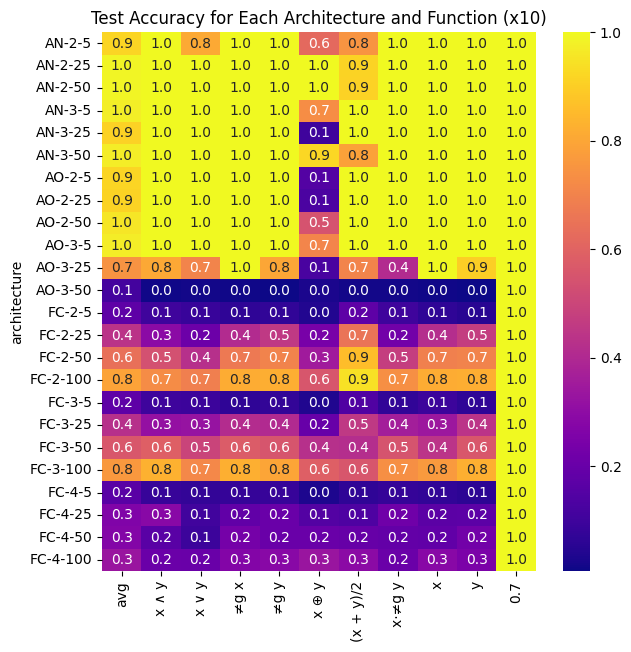

In [5]:
# plot heatmap
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(
    table_1.set_index("architecture"),
    annot=True,
    fmt=".1f",
    ax=ax,
    cmap="plasma",
)
plt.title("Test Accuracy for Each Architecture and Function (x10)")
plt.savefig("table_1.png")
plt.show()